In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T

import os

import matplotlib.pyplot as plt

## Create Deconvolution Layer

In [94]:
class Deconv2D(nn.Module):
    def __init__(self, shape=(2, 4)):
        super(Deconv2D, self).__init__()
        self.w_flat = nn.Parameter(data=torch.zeros(shape[0]*shape[1]-1),
                                   requires_grad=True)
        self.h_shape = shape

    def forward(self, x):
        w = nn.functional.pad(self.w_flat, (1, 0), value=1)

        w = torch.reshape(w, self.h_shape)
        hm1 = nn.functional.pad(w, (0, x.size(-1)-w.size(-1), 0, x.size(-2)-w.size(-2)))

        gm1f = 1/fft2(hm1)

        gm2f = torch.flip(gm1f, (0,))
        gm2f = torch.roll(gm1f, shifts=1, dims=0)

        gm3f = torch.flip(gm1f, (1,))
        gm3f = torch.roll(gm1f, shifts=1, dims=1)

        gm4f = torch.flip(gm1f, (0, 1))
        gm4f = torch.roll(gm1f, shifts=(1, 1), dims=(0,1))

        gmf = gm1f*gm2f*gm3f*gm4f

        ymf = gmf*fft2(x)

        y = ifft2(ymf).real

        return y

## Mount my Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and preprocess image

In [ ]:
base_path = 'drive/MyDrive/data/lena/'
img = torchvision.io.read_image(base_path+'Lenna.png',
                                torchvision.io.ImageReadMode.GRAY)

img = T.Resize((48, 48))(img)

img = nn.functional.pad(img, (24, 24, 24, 24))
img = img / 255.0
img.size()

torch.Size([1, 96, 96])

## Blur the image

In [86]:
w = torch.FloatTensor([[1, 0.2, 0, 0], [0, 0, 0, 0]])

# 4 factor blur

hm1 = nn.functional.pad(w, (0, img.size(-1)-w.size(-1), 0, img.size(-2)-w.size(-2)))

gm1f = fft2(hm1)

gm2f = torch.flip(gm1f, (0,))
gm2f = torch.roll(gm1f, shifts=1, dims=0)

gm3f = torch.flip(gm1f, (1,))
gm3f = torch.roll(gm1f, shifts=1, dims=1)

gm4f = torch.flip(gm1f, (0, 1))
gm4f = torch.roll(gm1f, shifts=(1, 1), dims=(0,1))

gmf = gm1f*gm2f*gm3f*gm4f

ymf = gmf*fft2(img)

X = ifft2(ymf).real

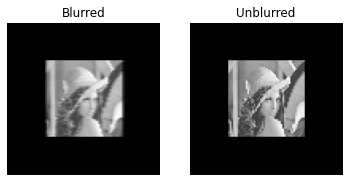

In [90]:
plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(X[0, :, :], cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 2, 2)
plt.imshow(img[0, :, :], cmap='gray')
plt.axis('off')
plt.title('Unblurred')

plt.show()

## Intialise optimizer and loss function

In [134]:
# Initialise variables
model = Deconv2D((2, 4))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

y = img

## Train deconv layer on the image

In [135]:
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()

    with torch.set_grad_enabled(True):
        outputs = model(X)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1)%50 == 0:
        print('Epoch {:04d} loss: {:.4f}'.format(epoch+1, loss))
    

Epoch 0050 loss: 0.0034
Epoch 0100 loss: 0.0029
Epoch 0150 loss: 0.0025
Epoch 0200 loss: 0.0021
Epoch 0250 loss: 0.0018
Epoch 0300 loss: 0.0015
Epoch 0350 loss: 0.0013
Epoch 0400 loss: 0.0011
Epoch 0450 loss: 0.0010
Epoch 0500 loss: 0.0008
Epoch 0550 loss: 0.0007
Epoch 0600 loss: 0.0007
Epoch 0650 loss: 0.0006
Epoch 0700 loss: 0.0005
Epoch 0750 loss: 0.0005
Epoch 0800 loss: 0.0004
Epoch 0850 loss: 0.0004
Epoch 0900 loss: 0.0003
Epoch 0950 loss: 0.0003
Epoch 1000 loss: 0.0003


## Unblur image using deconv layer

In [138]:
model.eval()
y_pred = model(X)

## Plot Original, Blurred, and Deblurred

Text(0.5, 1.0, 'Original')

<Figure size 8000x24000 with 0 Axes>

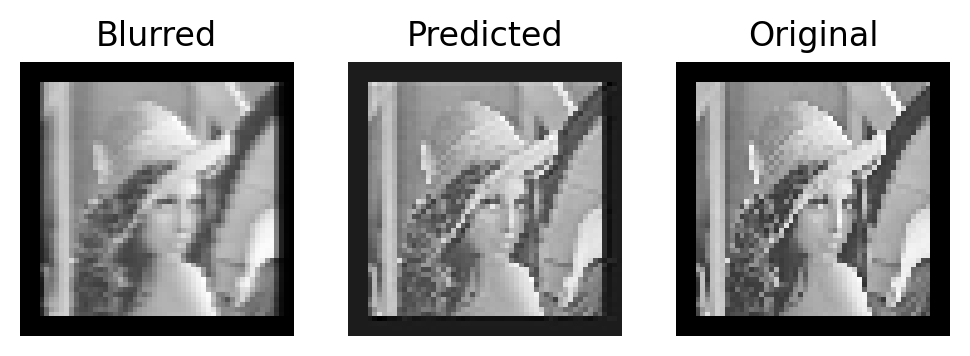

In [139]:
plt.rcParams['figure.dpi'] = 200
plt.figure(figsize=(40, 120))

plt.subplots(1, 2)

plt.subplot(1, 3, 1)
plt.imshow(X[0, 20:76, 20:76], cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[0, 20:76, 20:76].detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(img[0, 20:76, 20:76], cmap='gray')
plt.axis('off')
plt.title('Original')

## Deconvolution Kernel

In [140]:
model.w_flat

Parameter containing:
tensor([ 0.1332,  0.0300,  0.0131,  0.0212,  0.0308, -0.0123, -0.0161],
       requires_grad=True)